In [31]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/pj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Preprocessing
Integrating datasets into two data frames, True and False

In [32]:
df1 = pd.read_csv('Data/archive/Fake.csv')
df1['label'] = 'Fake'
del df1['subject']
del df1['date']

In [33]:
df2 = pd.read_csv('Data/archive/True.csv')
df2['label'] = 'True'
del df2['subject']
del df2['date']

In [34]:
df3 = pd.read_csv('Data/fake_or_real_news.csv')
del df3['Unnamed: 0']
df3['label'] = df3['label'].replace(['FAKE', 'REAL'], ['Fake', 'True'])

In [35]:
df4 = pd.read_csv('Data/fake.csv')
df4['label'] = 'Fake'
df4 = df4[['title', 'text', 'label']].copy()

In [36]:
frames = [df1, df2, df3, df4]
data = pd.concat(frames)
data.sample(20)

,title,text,label
17189,OBAMA WILL GIVE AWAY FREE INTERNET (To Those H...,Don t turn off your paid internet service quit...,Fake
6207,Treasury nominee Mnuchin says long-term dollar...,WASHINGTON (Reuters) - U.S. Treasury Secretary...,True
16166,Expulsion of Australian ministers cast doubt o...,SYDNEY (Reuters) - Australia s main Labor oppo...,True
15215,Saudi Arabia faces battle to repatriate assets...,DUBAI/ZURICH (Reuters) - Saudi Arabia has anno...,True
2284,Currency Crisis: Alasdair MacLeod On The Vexed...,Tweet Home » Gold » Gold News » Currency Crisi...,Fake
1715,The Tragically Hip’s Gord Downie: A True Canad...,For those of you who have no clue who Gord Dow...,Fake
667,Former U.S. Vice President Biden leaves open d...,WASHINGTON (Reuters) - Former U.S. Vice Presid...,True
17231,"UK says needs 1,200 officials to register EU n...",LONDON (Reuters) - Britain will need a total o...,True
21393,Danish police identify torso as missing submar...,COPENHAGEN (Reuters) - Police on Wednesday ide...,True
9864,"On Oklahoma bombing anniversary, a pitch for G...",(Reuters) - Victim advocates and former prosec...,True


### Modified data quality report
Helps determine what further cleaning needs to be done

In [37]:
# Constructing a data quality report for the data
cat_data = {'Feature': ['title', 'text', 'label'],
            'Count': data.count(),
            '% Missing': data.isnull().sum() * 100 / len(data),
            'Cardinality': data.apply(pd.Series.nunique),
            'Mode': [data.mode()['title'][0], 'null', data.mode()['label'][0]],
            'Mode Freq.': ['14', '769', '39644'],
            'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
    
            'Notes': ['', '', '']}
cat_dqr_df = pd.DataFrame(cat_data)
cat_dqr_df.reset_index(drop=True, inplace=True)
cat_dqr_df

,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,63552,1.058662,53541,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,64186,0.071615,54064,null,769,1.198081,
2,label,64232,0.000000,2,Fake,39644,61.720015,


In [38]:
data.drop_duplicates(inplace = True)

dfTrue = data[data['label'] == 'True']
dfFake = data[data['label'] == 'Fake']

dfFake.info()
dfTrue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30752 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   30122 non-null  object
 1   text    30706 non-null  object
 2   label   30752 non-null  object
dtypes: object(3)
memory usage: 961.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24351 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24351 non-null  object
 1   text    24351 non-null  object
 2   label   24351 non-null  object
dtypes: object(3)
memory usage: 761.0+ KB


In [39]:
# Train using 20% 
dfTrue = dfTrue.head(int(0.2 * dfTrue.shape[0]))
dfFake = dfFake.head(int(0.2 * dfFake.shape[0]))

### Data Cleaning
Removing stopwords, punctuation, and whitespace characters

In [40]:
def clean_string(input):
    stops = set(stopwords.words("english"))  # Set of stopwords

    input_tokenized = word_tokenize(input)   # Tokenize input
    input_without_sw = [word for word in input_tokenized if not word in stops]  # Remove stopwords
    input = (" ").join(input_without_sw)  # Combine back into sentence

    input = input.lower()
    input = re.sub('\n|\r|\t', '', input)   # Remove whitespace chars
    input = re.sub(r'[^\w\s]+', '', input)  # Remove punctuation
    
    
    return input

def preprocess(df):
    df.dropna(axis=0, inplace = True)  # Remove rows with missing values
    cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
    df['title'] = cleanfunc(df['title'])
    df['text'] = cleanfunc(df['text'])
    return df

In [41]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

### Feature Extraction & Visualization

#### Character Count in Title and Text

In [47]:
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]


def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Characters', title=f'Average Character Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  

def character_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Count Distribution of title


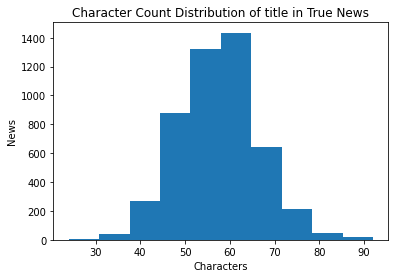

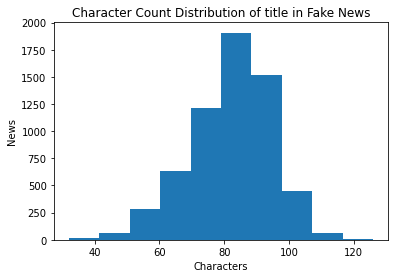

Average Count of title


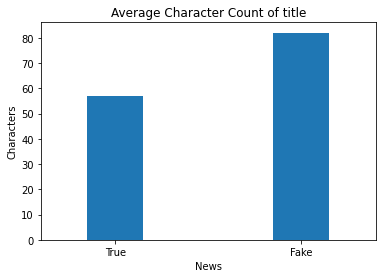

Character Count Distribution of text


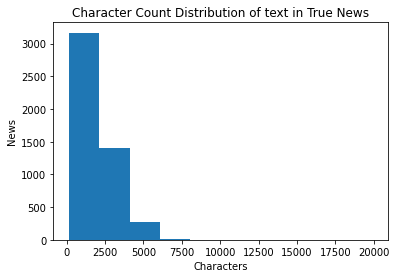

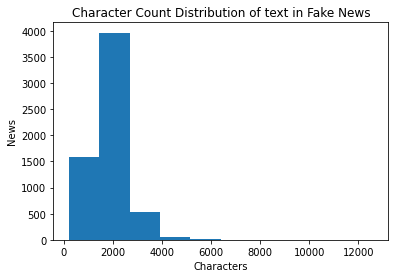

Average Count of text


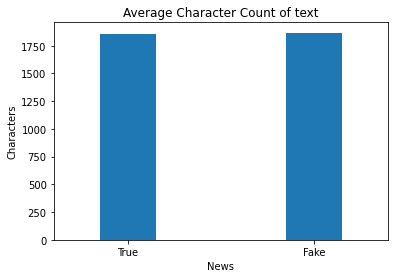

In [50]:
character_stats(dfTrue, dfFake, 'title')
character_stats(dfTrue, dfFake, 'text')

#### Word count in Title and Text

In [48]:
vectorizer = CountVectorizer()

def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  

def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)


Word Count Distribution of title


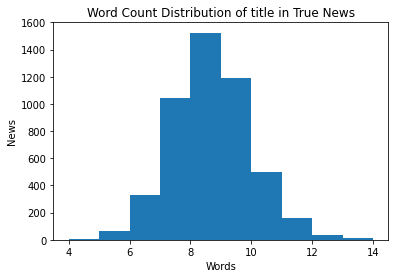

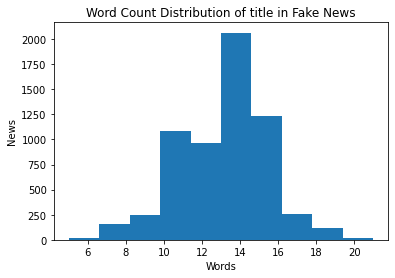

Average count of title


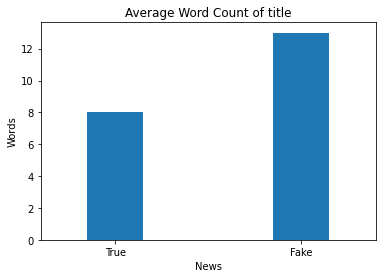

Word Count Distribution of text


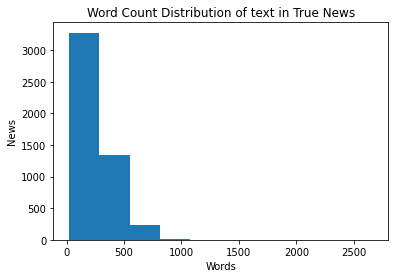

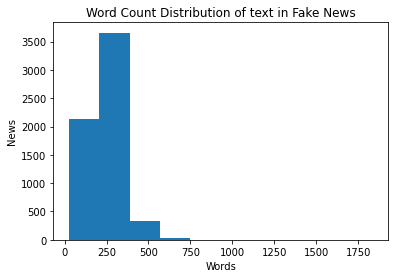

Average count of text


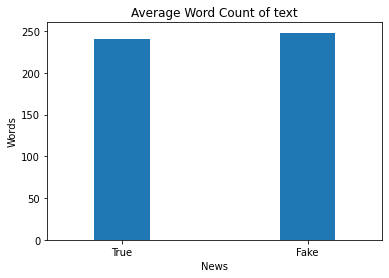

In [49]:
word_stats(dfTrue, dfFake, 'title')
word_stats(dfTrue, dfFake, 'text')